# [NML-24] Assignment 2: Graph Neural Networks

TAs: [William Cappelletti](https://people.epfl.ch/william.cappelletti) and [Abdellah Rahmani](https://people.epfl.ch/abdellah.rahmani)

## Students

* Team: 5
* Students: Hans Kristian Bjorgo Kvaerum (381875), Kaede Johnson (357472)

## Instructions

**!! Read carefully before starting !!**

**Deadline:** April 30

**Grading:**
* The integrality of Assignment 2 will be scaled to 100% and will amount to 1/3 of the overall assignments score.
* The total number of points is **100**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable or function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored.

* You cannot import any other library than we imported, unless explicitly stated.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTex-equations

## Objective

This assignment focuses on Graph Neural Networks. In the first part, you will load and prepare data using the PyTorch Geometric library. Next, you will define a GNN used to solve a task. You will train and test the Neural Network and comment on the results.
In the second part, you will define a new GNN block, in order to include it in the previous architecture.
The third part is theoretical and study a way to include structural properties in learned networks.

## Prerequisites

The additional [tutorial notebook](nml24_gnn_tutorial.ipynb) provides a broad overview of PyTorch and PyTorch Geometric, showing how to manipulate tensors and train neural networks and GNNs.

The following resources might help you familiarize with PyTorch and PyTorch geometric.

* [PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)
* [PyTorch geometric: Official tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html#official-examples)


## Part 0: Explore the data [0 points]

This part contains no questions, but we will go together through the data to get a feeling of their content.
We work with the [GitHub dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.GitHub.html), from the ["Multi-scale Attributed Node Embedding"](https://arxiv.org/abs/1909.13021) paper.
In this dataset, nodes represent developers on GitHub and edges are mutual follower relationships. It contains 37,300 nodes, 578,006 edges, 128 node features and 2 classes.

This data is readily available in PyTorch Geometric, let's start by installing it.

In [ ]:
!pip install torch_geometric -q
!pip install pyg_lib -f https://data.pyg.org/whl/torch-2.2.0+cu121.html -q
# !pip install pyg_lib -f https://data.pyg.org/whl/torch-2.0.0+cpu.html -q # Change to supported version: https://pypi.org/project/pyg-library/
!pip install torchmetrics -q

Then, we can import all relevant libraries. Some of them will be useful in later steps.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric as pyg
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.datasets import GitHub
from torchmetrics import Metric
from torchmetrics.classification import Accuracy, BinaryF1Score, Precision, Recall

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Added by student: Metal-acceleration (MPS) for GPU acceleration on Apple ARM
# device = "mps:0" if torch.backends.mps.is_available() else "cpu"

Let's download the data.

In [ ]:
dataset = GitHub(".")
data = dataset._data

Now, we shall study its content. Node attributes are accessible through the `x` attribute, which is a `torch.Tensor`.

In [ ]:
print("Design matrix")
n_nodes, n_feats = data.x.shape
print(f"Num. nodes: {n_nodes}; num features: {n_feats}")

Design matrix
Num. nodes: 37700; num features: 128


We see that we have 37,700 nodes, each with 128 features. The features correspond to an embedding of location, starred repositories, employer and e-mail address of each user.

Each node comes with a 0/1 label, which indicates whether it corresponds to a web, or a machine learning developer.

In [ ]:
print("Target vector")
print("First five elements:", data.y[:5])
print("Number of samples:", data.y.shape)
print("Number of nodes in class 1:", data.y.sum().item())

Target vector
First five elements: tensor([0, 0, 1, 0, 1])
Number of samples: torch.Size([37700])
Number of nodes in class 1: 9739


We see that the task is quite imbalanced, as class one is underrepresented. To get more meaningful interpretations, we swap classes zero and one.

In [ ]:
data.y = 1 - data.y

The edges are contained in the `edge_index` attribute, which is again a tensor. Let's check its shape.

In [ ]:
print("Edge index shape:", data.edge_index.shape)

Edge index shape: torch.Size([2, 578006])


**0.1 [0 points]** Describe the content of the edge index matrix and how it relates to the adjacency matrix.

The `edge_index matrix` in PyTorch Geometric is used to represent the connectivity of the graph, and consists of two rows and columns representing edges between two nodes. More specifically, the first row contains the source nodes of the edges, while the second row contains the destination nodes of the edges. As a consequence, the entries of the matrix are node indices. Due to its compact nature, the `edge_index matrix` can be seen as a sparse representation of the `adjacency matrix`, where only the non-zero entries (i.e., existing edges) are stored. This leads to dimensionality of $2 \times |E|$ for the `adjacency matrix`, compared to $N \times N$ for the `adjacency matrix`(N is the number of nodes). Naturally, this makes `edge_index` particularly memory efficient for sparse graphs, where the number of edges is much smaller than $N^2$.

---

Now, we will create two random binary masks on the nodes: one for training and one for testing. We would like to have 70% of the samples in the training split, so we will uniformly pick nodes with that probability.

We use a masking strategy instead of directly splitting the data because our interpretation of the task is that we have a social network in which the training label are accessible, while the test nodes, even though available, are unknown. This simplifies the sampling strategy, in particular for network methods, as we do not have to worry about loosing structure.

In [ ]:
rng = torch.Generator().manual_seed(452)
train_mask = torch.randn(n_nodes, generator=rng) < 0.8

n_nodes_tr = train_mask.sum().item()
print(f"Training set size: {n_nodes_tr} ({n_nodes_tr / n_nodes:.2%})")
print(f"Test set size: {n_nodes - n_nodes_tr} ({1 - n_nodes_tr / n_nodes:.2%})")
print(
    f"Ratio of class 1 in training: {torch.sum(train_mask * data.y).item() / n_nodes_tr:.2%}"
)

Training set size: 29636 (78.61%)
Test set size: 8064 (21.39%)
Ratio of class 1 in training: 74.12%


We saw that the graph has 37,700 nodes, which means that the dense adjacency matrix has 1,421,290,000 entries.
Supposing that binary variables are stored in a single bit, this would still require ~170 MB to store. With 8bit integers or floats it would occupy more than 10 GB, but with mainly zero values.

Since each node can fit in 16 bits, this representation can fit in 2.2 MB.

## Part 1: Deep learning on graph data [45 points]

This part presents a general workflow for deep learning and our recommended libraries: PyTorch and PyTorch Geometric.
We will start with classical ML baselines, to get some robust results to which we can compare. Then we will introduce Network features, to see whether they can help in our task. Finally, we start working with deep learning, and graph neural networks.

### Question 1.1: Our first baseline (4 points)

In this question we define a baseline model with a "classical" ml method, namely a random forest, to get an idea of what performances we can expect from the following models.
This model will only use node features, so it does not leverage at all the graph structure.

**1.1.1 [2pts]** Train a random forest classifier based on the node features. Make sure to use the provided `train_mask` for both the features and the target labels.

In [ ]:
# Your solution here ###########################################################
X_train = data.x[train_mask].numpy()
y_train = data.y[train_mask].numpy()

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomForestClassifier(random_state=42)

**1.1.2 [1pts]** Predict the labels of the test nodes, then print the `classification_report`.

In [ ]:
# Your solution here ###########################################################

# Test mask = inverted train_mask (to prevent data leakage)
test_mask = ~train_mask

# Prepare the test data
X_test = data.x[test_mask].numpy()
y_test = data.y[test_mask].numpy()

# Predict the labels for the test data
y_pred = rf_classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      2070
           1       0.88      0.95      0.91      5994

    accuracy                           0.86      8064
   macro avg       0.84      0.78      0.80      8064
weighted avg       0.86      0.86      0.86      8064



**1.1.3 [1pt]** Discuss which of the metrics is the most informative one for our setting.

Given the class-imbalance observed in the dataset (class 0 contributing ~25% of the test examples), the f1-score is arguably the most informative and useful metric in this setting. F1 Score is a harmonic mean of precision (accuracy of positive predictions) and recall (ability of the model to find all the positive samples), thus giving a more balanced indication of the classifiers true performance. Accuracy is not that informative for our setting as a model could uniformly predict class 1 and achieve 0.75 accuracy score on the test examples, thus fooling us into believing it's moderately effective (when it would in fact be completely useless).

### Question 1.2: Graph baseline - Laplacian eigenmaps (5 points)

Now, let's implement a second benchmark, this time relying on structural properties. We would like to use eigenmaps of the Laplacian, but if you try to do it you would quickly run out of memory! (Go ahead and try if you will 😉)

The adjacency matrix is too big to use it in computations, but it would be mainly filled with zeros. We can optimize memory and running time by using a **sparse representation**.

**1.2.1 [1pts]** Compute the Laplacian matrix as a [sparse SciPy array][scipy_sparse]. Start by creating a sparse adjacency matrix form the `edge_index`, supposing that all edge weights are 1.

[scipy_sparse]: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [ ]:
import numpy as np
from scipy import sparse

edge_index = data.edge_index.numpy()

# Convert edge_index to a sparse adjacency matrix
n = data.num_nodes
rows, cols = edge_index
values = np.ones(len(rows))  # Assuming all edge weights are 1
adjacency = sparse.coo_matrix((values, (rows, cols)), shape=(n, n), dtype=np.float32)

# Ensure the adjacency matrix is symmetric
adjacency = adjacency + adjacency.T
adjacency.data = np.clip(adjacency.data, 0, 1)  # Remove possible double edges

# Convert to CSR format for better arithmetic operations
adjacency = adjacency.tocsr()

# Compute degree matrix
degrees = np.array(adjacency.sum(axis=1)).flatten()
degree_matrix = sparse.diags(degrees)

# Compute Laplacian matrix
laplacian = degree_matrix - adjacency

print(f"Sparse format of Laplacian: {type(laplacian)}")
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Sparse format of Laplacian: <class 'scipy.sparse._csr.csr_matrix'>


**1.2.2 [1pts]** Use SciPy sparse linear algebra capabilities to compute the first 5 nontrivial eigenvectors of the Laplacian.

*Note: This takes ~15 minutes, so you can change the condition to False after completing Question 1.2 to iterate more quickly over the following ones.

In [ ]:
# Your solution here ###########################################################
find_eigvecs = True

if find_eigvecs:  # Change to True to run cell
    # Compute the first 6 smallest eigenvalues and corresponding eigenvectors
    # NOTE: Change default 'LM' to 'SM' because of eigenvalue ordering (ascending) presented in slide 14 lecture "Spectral Graph Theory"
    eigvals, eigvecs = sparse.linalg.eigsh(laplacian, k=6, which='SM')
    # Exclude the first trivial eigenvector (corresponding to the eigenvalue 0)
    eigvecs = eigvecs[:, 1:6]

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
else:
    eigvecs = np.random.rand(n_nodes, 5)


**1.2.3 [1pts]** Train and test a new random forest classifier using the eigenvector representation as features.

In [ ]:
# Your solution here ###########################################################

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare the training and testing data
X_train = eigvecs[train_mask]
y_train = data.y[train_mask].numpy()

X_test = eigvecs[test_mask]
y_test = data.y[test_mask].numpy()

# Create the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = rf_classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.76      0.21      0.33      2070
           1       0.78      0.98      0.87      5994

    accuracy                           0.78      8064
   macro avg       0.77      0.59      0.60      8064
weighted avg       0.78      0.78      0.73      8064



**1.2.4 [1pts]** Now, combine the two sets of features, i.e. the given programmers features and the Laplacian eigenmaps, into a single design matrix, then train and test another RF.

In [ ]:
# Your solution here ###########################################################

combined_features = np.hstack((data.x.numpy(), eigvecs))

# Prepare the training and testing data using combined features
X_train = combined_features[train_mask]
X_test = combined_features[test_mask]

# Create and train the random forest classifier
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_train, y_train)

# Predict the labels of the test set using the combined feature classifier
y_pred = rf_combined.predict(X_test)

# Print the classification report for the combined features model
print(classification_report(y_test, y_pred))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      2070
           1       0.88      0.95      0.91      5994

    accuracy                           0.87      8064
   macro avg       0.84      0.79      0.81      8064
weighted avg       0.86      0.87      0.86      8064



**1.2.5 [1pts]** Comment on the results and describe which model you expect to perform the best on unseen dataset.



Comparing the classification report prints, we observe that combining the node features with eigenvector representations very slightly boosts performance for class 0 (+0.01 in F1-score) while yielding no change for class 1. We also observe that the eigenvector representations alone yield the worst RF classifier; the performance differential is particularly bad for the under-represented class 0 nodes, as F1-score for these nodes drops 43 percentage points when original features are removed). This suggests class-labels are probably more correlated with node features than structural information captured by the eigenectors.

Because we are using a random forest classifier, we would use the version with the original features + the eigenvectors to classify unseen data, even if we expect its performance to be similar to the model with original features only. This is because the random forest classifier can benefit from having extra features for discriminative power - and if these extra features (ie eigenvectors) contain little by way of information gain, rather than harm our classifier they will simply be disregarded in the decision tree. Based on the fact that the eigenvectors yielded very limited performance boost in the tests above and the assumption that unseen data would be drawn from the same distribution as our data above, we would nonetheless expect the model with original features alone to be an acceptable choice.

---

### Question 1.3: Neural Network baseline - MLP (16 points)

In this question, we move from classical ML to deep learning and, again, we start from a simple model to get a viable benchmark.

**1.3.1 [2pts]** Create two `DataLoaders`, for the training and test data respectively, by using the `TensorDataset` class. Use the predefined batch size and shuffle training data.

References:
- [Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [PyTorch data utility](https://pytorch.org/docs/stable/data.html)

In [ ]:
batch_size = 128

# Your solution here ###########################################################

# Assumption: only consider provided node features (ignore eigenvectors for this part)
X_train = data.x[train_mask].clone().detach().to(device)
y_train = data.y[train_mask].clone().detach().to(device)
X_test = data.x[~train_mask].clone().detach().to(device)
y_test = data.y[~train_mask].clone().detach().to(device)

# Create dataloaders
loader_train = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
loader_test = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.2 [2pts]** Define a [torch module][nn_module] for a two-layer perceptron with the ReLU activation function. The hidden dimension will be a parameter of the constructor function.
This neural network will take as input a design matrix and predict the "logits" of class 1.

[nn_module]: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [ ]:
class MLP(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_features: int, hidden_features: int):
        super(MLP, self).__init__()
        '''
        Setup:
        - Layer 1: input layer: input_dim -> hidden_dim
        - Layer 2: output layer: hidden_dim -> 1 (class prediction)
        - Activation function: ReLU
        '''
        self.layer1 = nn.Linear(in_features, hidden_features)
        self.layer2 = nn.Linear(hidden_features, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass for the network
        - Pass the input through the first layer, then apply ReLU
        - Pass the result of the first layer through the second layer to produce output logits
        """
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        return x
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.3 [1pts]** Define a function to perform one training step for a given NN, taking as argument a batch of data `x` with target `y`, an [optimizer](torch_optim), and a [loss function](torch_loss). The function should return the loss value, as a float.

In [ ]:
def train_nn_step(
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.train()  # Used to ensure that relevant blocks are in training mode

    # Your solution here #######################################################
    '''
    1. Clear previous optimizer gradients
    2. Get model outputs and squeeze to match y.shape
    3. Compute loss
    4. Backpropagate loss and update parameters
    '''
    optimizer.zero_grad()
    outputs = model(x).squeeze() # Changes shape from [batch_size, 1] to [batch_size]
    loss = loss_fn(outputs, y.float())
    loss.backward()
    optimizer.step()

    return loss.item()

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.4 [2pts]** Write an evaluation function that takes as input a PyTorch Module, a data loader, and a [TorchMetrics function][torchmetrics] and returns the cumulative metric over all batches.

[TorchMetrics][torchmetrics] is a convenient package that implements metrics that work with PyTorch Tensors, and also with batched data.

[torchmetrics]: https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html

In [ ]:
def eval_nn(model: nn.Module, loader: DataLoader, metric_fn: Metric) -> float:
    model.eval()  # Used to ensure that relevant block are in evaluation model

    # Your solution here #######################################################
    '''
    1. Iterate over all batches:
        a. Compute model outpus and squeeze to match y_batch.shape
        b. Apply sigmoid function to convert logits to probabilities
            - Intuition: sigmoid is used for binary classification, softmax is used for multi-class classification
        c. Update metric_fn
    2. Compute before reset metric_fn
    '''
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch).squeeze()
            preds = torch.sigmoid(outputs)
            metric_fn.update(preds, y_batch.float())

    final_metric = metric_fn.compute()
    metric_fn.reset()

    return final_metric

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.5 [2pts]** Create an instance of the previously defined MLP, a relevant [loss function][torch_loss] for our classification task, and an [optimizer](torch_optim).
When needed, as for the MLP hidden dimension and optimizer learning rate, select parameters that provide good results for the task. You might need some trial-and-error, so keep track of you results as you will be asked to comment on those hyperparameters.

Make sure to send everything to the correct device at initialization, as moving information from the CPU to the GPU is time-consuming.
To use GPUs, you might have to change runtime type.

[torch_loss]: https://pytorch.org/docs/stable/nn.html#loss-functions
[torch_optim]: https://pytorch.org/docs/stable/optim.html


In [ ]:
print(f"Using {device} device")

# Your solution here ###########################################################

# Define the input feature size and hidden layer size
in_features = X_train.shape[1]
hidden_features = 64

# Initialize model
mlp = MLP(in_features=in_features, hidden_features=64).to(device)

# Loss function: Binary Cross-Entropy with logits loss (Combines BCE-loss and sigmoid in one single class)
loss_fn = nn.BCEWithLogitsLoss()

# Initialize Aadam optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using mps:0 device


**1.3.6 [3pts]** Perform 10 epochs of training. During each epoch, you should perform training steps iterating over the whole dataset. Gather the losses of each batch, and plot the evolution of the training loss at the end.

Epoch 1/15, Avg Loss: 0.4019
Epoch 2/15, Avg Loss: 0.3459
Epoch 3/15, Avg Loss: 0.3380
Epoch 4/15, Avg Loss: 0.3328
Epoch 5/15, Avg Loss: 0.3267
Epoch 6/15, Avg Loss: 0.3218
Epoch 7/15, Avg Loss: 0.3158
Epoch 8/15, Avg Loss: 0.3101
Epoch 9/15, Avg Loss: 0.3040
Epoch 10/15, Avg Loss: 0.2990
Epoch 11/15, Avg Loss: 0.2930
Epoch 12/15, Avg Loss: 0.2884
Epoch 13/15, Avg Loss: 0.2820
Epoch 14/15, Avg Loss: 0.2776
Epoch 15/15, Avg Loss: 0.2731


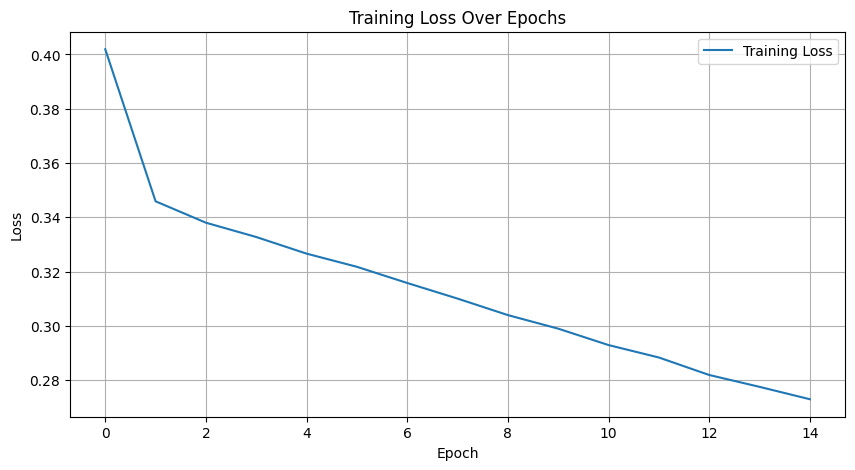

In [ ]:
from tqdm import tqdm

n_epochs = 15

# Your solution here ###########################################################
def train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs, verbose=False):
    optimizer.zero_grad()
    all_losses = []

    for epoch in range(n_epochs):
        epoch_losses = []

        if verbose:
            # Wrap the DataLoader with tqdm for visual progress
            iterable = tqdm(loader_train, desc=f"Epoch {epoch+1}/{n_epochs}")
        else:
            iterable = loader_train

        for x_batch, y_batch in iterable:
            # Move data to the correct device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Perform a training step
            loss = train_nn_step(optimizer, loss_fn, mlp, x_batch, y_batch)
            epoch_losses.append(loss)

            if verbose:
                # Update progress bar with the current batch loss
                iterable.set_postfix({'loss': loss})

        # Record average loss for this epoch
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Avg Loss: {avg_loss:.4f}")

    return all_losses

all_losses = train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**1.3.7 [1pts]** Evaluate the trained model on both the training and test data, using the most relevant metric from those already imported from TorchMetrics.

In [ ]:
# Your solution here ###########################################################

# Alternatives: Accuracy, BinaryF1Score, Precision, Recall -> Choice: BinaryF1Score due to class-imbalances seen in previous tasks
metric_fn = BinaryF1Score(threshold=0.5).to(device)

# Evaluate the model on train and test set
metric_tr = eval_nn(mlp, loader_train, metric_fn)
metric_te = eval_nn(mlp, loader_test, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.931
Test metric:     0.902


**1.3.8 [3pts]** Try different hyperparameters' combinations, in particular for the hidden dimension of the MLP and the learning rate of the optimizer. Then discuss the obtained results and the learning curves.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 4


Epoch 1/15, Avg Loss: 0.5274
Epoch 2/15, Avg Loss: 0.3756
Epoch 3/15, Avg Loss: 0.3536
Epoch 4/15, Avg Loss: 0.3482
Epoch 5/15, Avg Loss: 0.3457
Epoch 6/15, Avg Loss: 0.3438
Epoch 7/15, Avg Loss: 0.3429
Epoch 8/15, Avg Loss: 0.3422
Epoch 9/15, Avg Loss: 0.3412
Epoch 10/15, Avg Loss: 0.3406
Epoch 11/15, Avg Loss: 0.3401
Epoch 12/15, Avg Loss: 0.3400
Epoch 13/15, Avg Loss: 0.3395
Epoch 14/15, Avg Loss: 0.3391
Epoch 15/15, Avg Loss: 0.3387
Train F1 Score: 0.909, Test F1 Score: 0.910
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 8
Epoch 1/15, Avg Loss: 0.5528
Epoch 2/15, Avg Loss: 0.3662
Epoch 3/15, Avg Loss: 0.3510
Epoch 4/15, Avg Loss: 0.3465
Epoch 5/15, Avg Loss: 0.3437
Epoch 6/15, Avg Loss: 0.3423
Epoch 7/15, Avg Loss: 0.3402
Epoch 8/15, Avg Loss: 0.3391
Epoch 9/15, Avg Loss: 0.3379
Epoch 10/15, Avg Loss: 0.3367
Epoch 11/

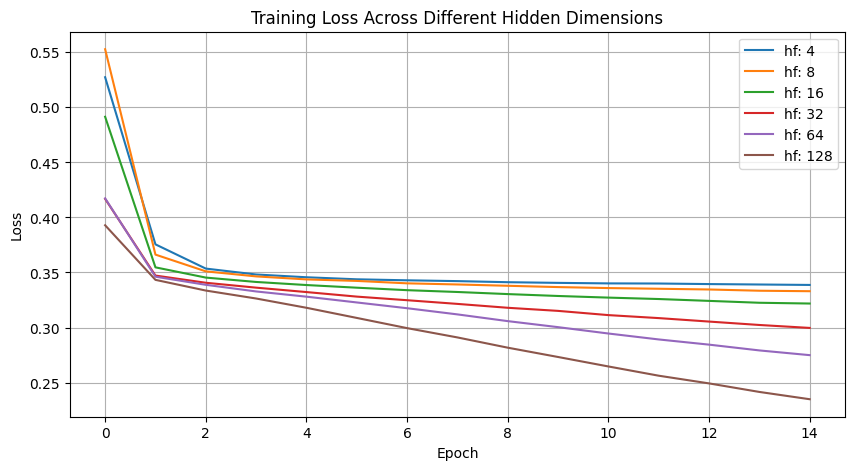

lr: 0.001 


In [ ]:
# Set of hidden dimensions to test
hidden_features = [4,8,16,32,64,128]

# Test setup
in_features = X_train.shape[1]
learning_rate = 0.001
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)
model_evaluation = []

# Initialise plot for the losses
plt.figure(figsize=(10, 5))

for hf in hidden_features:
    print("- - - "*30)
    print('Training with hidden dimension:', hf)

    # Initialise new model and optimizer
    mlp = MLP(in_features=in_features, hidden_features=hf).to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

    # Train model
    losses = train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs, verbose=False)
    plt.plot(losses, label=f"hf: {hf}")

    # Evaluate model on train and test set
    metric_tr = eval_nn(mlp, loader_train, metric_fn)
    metric_te = eval_nn(mlp, loader_test, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")
    model_evaluation.append({'hidden_dim': hf, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Across Different Hidden Dimensions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print('lr:', learning_rate, "")

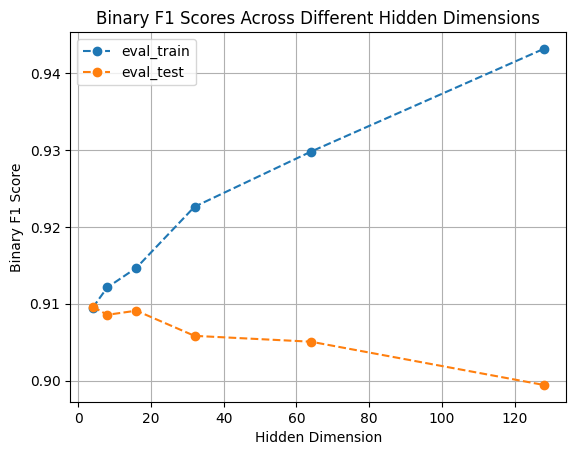

In [ ]:
plt.plot(hidden_features, [x['eval_tr'] for x in model_evaluation], label='eval_train', linestyle='--', marker='o')
plt.plot(hidden_features, [x['eval_te'] for x in model_evaluation], label='eval_test', linestyle='--', marker='o')
plt.title('Binary F1 Scores Across Different Hidden Dimensions')
plt.xlabel('Hidden Dimension')
plt.ylabel('Binary F1 Score')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with lr: 0.01


Epoch 1/15, Avg Loss: 0.4867
Epoch 2/15, Avg Loss: 0.3681
Epoch 3/15, Avg Loss: 0.3513
Epoch 4/15, Avg Loss: 0.3465
Epoch 5/15, Avg Loss: 0.3445
Epoch 6/15, Avg Loss: 0.3430
Epoch 7/15, Avg Loss: 0.3422
Epoch 8/15, Avg Loss: 0.3413
Epoch 9/15, Avg Loss: 0.3413
Epoch 10/15, Avg Loss: 0.3404
Epoch 11/15, Avg Loss: 0.3401
Epoch 12/15, Avg Loss: 0.3397
Epoch 13/15, Avg Loss: 0.3390
Epoch 14/15, Avg Loss: 0.3390
Epoch 15/15, Avg Loss: 0.3384
Train F1 Score: 0.910, Test F1 Score: 0.910
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with lr: 0.005
Epoch 1/15, Avg Loss: 0.5317
Epoch 2/15, Avg Loss: 0.3812
Epoch 3/15, Avg Loss: 0.3553
Epoch 4/15, Avg Loss: 0.3499
Epoch 5/15, Avg Loss: 0.3470
Epoch 6/15, Avg Loss: 0.3451
Epoch 7/15, Avg Loss: 0.3434
Epoch 8/15, Avg Loss: 0.3422
Epoch 9/15, Avg Loss: 0.3412
Epoch 10/15, Avg Loss: 0.3408
Epoch 11/15, Avg Lo

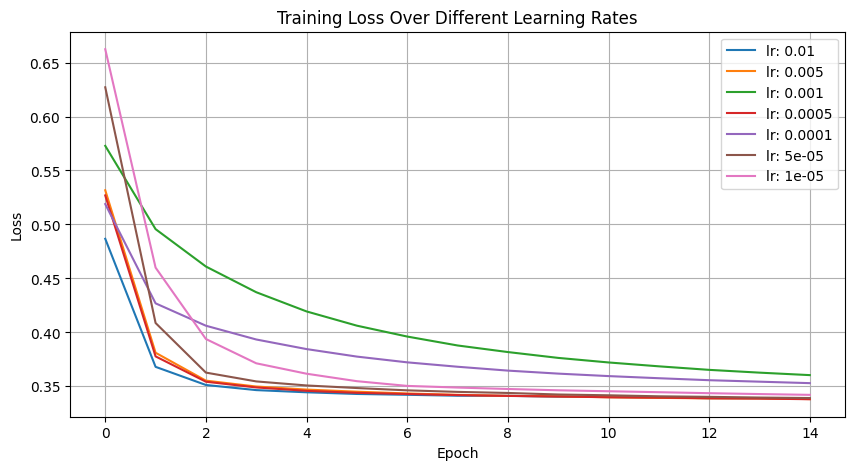

lr: 0.001 


In [ ]:
# Set of hidden dimensions to test
learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

# Test setup
in_features = X_train.shape[1]
hidden_dim = 4 # Best value wrt eval_test according to above plot
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)
model_evaluation = []

# Initialise plot for losses
plt.figure(figsize=(10, 5))

for lr in learning_rates:
    print("- - - "*30)
    print('Training with lr:', lr)

    # Initialise new model and optimizer
    mlp = MLP(in_features=in_features, hidden_features=hidden_dim).to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

    # Train model
    losses = train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs, verbose=False)
    plt.plot(losses, label=f"lr: {lr}")

    # Evaluate model on train and test set
    metric_tr = eval_nn(mlp, loader_train, metric_fn)
    metric_te = eval_nn(mlp, loader_test, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")
    model_evaluation.append({'lr': lr, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Over Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print('lr:', learning_rate, "")

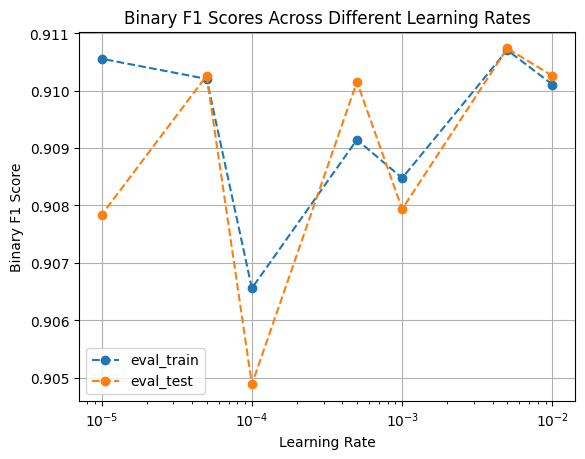

In [ ]:
plt.plot(learning_rates, [x['eval_tr'] for x in model_evaluation], label='eval_train', linestyle='--', marker='o')
plt.plot(learning_rates, [x['eval_te'] for x in model_evaluation], label='eval_test', linestyle='--', marker='o')
plt.title('Binary F1 Scores Across Different Learning Rates')
plt.xlabel('Learning Rate')
plt.semilogx()
plt.ylabel('Binary F1 Score')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**Your answer here:**
The first two plots above, depicting training dynamics and evaluation scores across various hidden dimensions, demonstrate the model's tendency to overfit the training data as the hidden dimension grows. Even though high-hidden-dimension models achieve the lowest training error, the highest hidden dimension tested yields a 1 percentage point drop in F1 score against the lowest hidden dimension tested. In fact, the models with hidden dimensions 4 and 16 achieve the best evaluation scores for our test set, suggesting these values are better choices for our particular task.

In light of these results, we used a hidden dimension of 4 to evaluate learning rates. We expected learning rates to possibly affect two things: rate of convergence and the local minima targeted during convergence. Considering the final plot above, we observe clear, non-monontonic fluctations in model performance for the different learning rates, confirming convergence toward different local minima. We also observe that larger learning rates led to quicker convergence, as expected. All training runs converged, suggesting all learning rates were valid choices for our task. Lr=5e-2 yielded the best evaluation scores on the test set.

### Question 1.4: Graph Neural Networks (20 points)

We will now shift from the standard deep learning paradigm to Graph Neural Networks, to leverage the additional structure of our data.

We already imported [PyTorch Geometric][torch_geometric] as `pyg`, so you can access its submodules as `pyg.nn`, `pyg.data` and so on.

[torch_geometric]: https://pytorch-geometric.readthedocs.io/en/latest/index.html

**1.4.1 [2pts]** Let's start by defining our first GNN. Again, it will be a subclass of the PyTorch `Module`, but this time it will take into account the `edge_index` in its `forward method`. Use two [GCN layers][gcn] to go from input features, here called *channels*, to a hidden dimension defined in the constructor, then to logit readout. Use ReLU activations.

This GNN will map node vectors to node logits, so we can directly read out node probabilities from

[gcn]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html

In [ ]:
import torch_geometric as pyg

class GCN(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
        super(GCN, self).__init__()

        '''
        - First GCN layer: input_size -> hidden_dim
        - Second GCN layer: hidden_dim -> output_size=1 (binary classification)
        - Activation function: ReLU
        '''
        self.conv1 = pyg.nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg.nn.GCNConv(hidden_channels, 1)  # Assuming output is 1-dimensional logits per node
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        '''
        GCN Forward pass:
        1. Pass input and edge_index through first GCN layer
        2. Apply ReLU activation function to layer 1 outputs
        3. Pass outputs of activation function throug second GCN layer
        NOTE: not activation function after last layer as we want raw logits as outputs
        '''
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.2 [3pts]** Perform `n_epochs` of training of a GCN model with 64 hidden channels, using full training data as a batch. Make sure to only use training data in the loss computation by using the `train_mask`. Track the loss value at each step and plot it. Finally, evaluate the model on train and test, using the `metric_fn` from before.

Epoch 1: Loss 0.6472446918487549
Epoch 2: Loss 0.6362761855125427
Epoch 3: Loss 0.6256106495857239
Epoch 4: Loss 0.6152495741844177
Epoch 5: Loss 0.6051914691925049
Epoch 6: Loss 0.5954359173774719
Epoch 7: Loss 0.5859838128089905
Epoch 8: Loss 0.5768352746963501
Epoch 9: Loss 0.5679877996444702
Epoch 10: Loss 0.5594324469566345
Epoch 11: Loss 0.5511617660522461
Epoch 12: Loss 0.5431616306304932
Epoch 13: Loss 0.5354278087615967
Epoch 14: Loss 0.5279557108879089
Epoch 15: Loss 0.5207417011260986


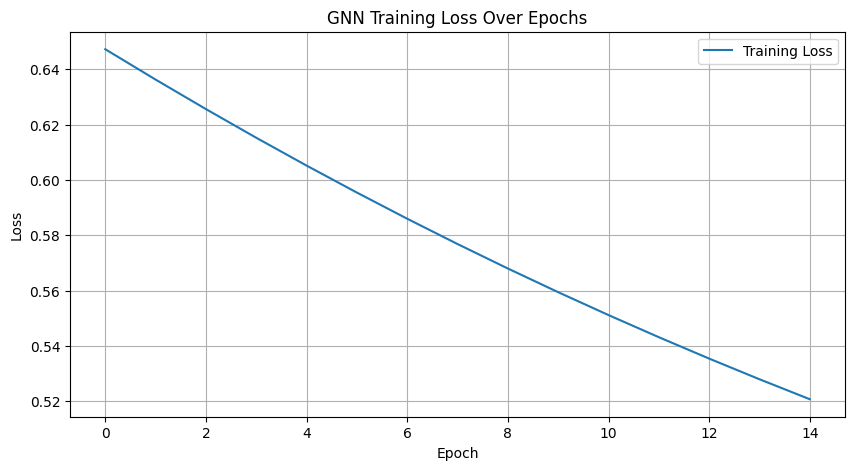

In [ ]:
from tqdm import tqdm

in_features = data.x.shape[1]
hidden_dim = 64

# Model Initialization
gcn = GCN(in_channels=in_features, hidden_channels=hidden_dim).to(device)

# Training Setup
n_epochs = 15
learning_rate = 1e-3
optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

# Based on train_nn. Modified a bit because our GCN model takes edge_index as an argument
def train_gnn(data, model, optimizer, loss_fn):

    # Ensure data is on the correct device
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    y = data.y.float().to(device)  # Convert to float if not already

    model.train()
    all_losses = []

    '''
    For each epoch of training:
    1. Clear previous gradients
    2. Get model output logits and squeeze to match y.shape
    3. Apply train_mask to logits and y to compute loss
    4. Backpropagate loss and update parameters
    '''
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        out = model(x, edge_index).squeeze()
        loss = loss_fn(out[train_mask], y[train_mask])
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}: Loss {loss.item()}")

    return all_losses
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

all_losses = train_gnn(data, gcn, optimizer, loss_fn)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.title('GNN Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Minor modification to eval_nn as GNN models require different input args (inclusion of edge_index)
def eval_gnn(model: nn.Module, data, mask: torch.Tensor, metric_fn: Metric) -> float:

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        '''
        1. Compute model outpus and squeeze to match y_batch.shape
        2. Apply sigmoid function to convert logits to probabilities
            - Intuition: sigmoid is used for binary classification, softmax is used for multi-class classification
        3. Update metric_fn
        '''
        outputs = model(data.x.to(device), data.edge_index.to(device)).squeeze()
        preds = torch.sigmoid(outputs)
        preds_masked = preds[mask]
        y_masked = data.y[mask].float().to(device)
        metric_fn.update(preds_masked, y_masked)

    final_metric = metric_fn.compute()
    metric_fn.reset()  # Reset the metric for future evaluations
    return final_metric


metric_fn = BinaryF1Score(threshold=0.5).to(device)
metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn),

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.865
Test metric:     0.867


**1.4.3 [2pts]** Hopefully, we got already some good results, but we would like to test whether stochastic optimization might be better. Batching graph data requires a particular approach, since on top of the design matrix with node features we have to account for edge information. In our setting, we have a single graph with many nodes, and a node level task. A batching strategy consists in sampling nodes with their neighbors, then working with this smaller graphs in a batched way.

Define one [NeighborLoader][neighborloader] for the training data, which will gather neighbors for as many *iterations* as layers in your GCN.

References:
- [Mini batches](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#mini-batches)

[neighborloader]: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader

In [ ]:
batch_size = 1024

# Your solution here ###########################################################
num_neighbours = 30
num_hops = 2

loader_graph_train = pyg.loader.NeighborLoader(
    data,
    num_neighbors=[num_neighbours] * num_hops,
    batch_size=batch_size,
    input_nodes=train_mask,
    shuffle=True,
    drop_last=False
)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.4 [1pt]** Use the previously defined `train_nn_step` to train a newly initialized GCN with the new loader. Again plot the loss evolution and evaluate the trained model on train and test data.

In [ ]:
# train_nn_step does not take edge_index as an argument, hence the modified implementation for GNNs
def train_gnn_step(
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    model: nn.Module,
    x: torch.Tensor,
    edge_index: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.train()  # Used to ensure that relevant blocks are in training mode

    # Your solution here #######################################################
    '''
    1. Clear previous optimizer gradients
    2. Get model outputs and squeeze to match y.shape
    3. Compute loss
    4. Backpropagate loss and update parameters
    '''
    optimizer.zero_grad()
    outputs = model(x, edge_index).squeeze() # Changes shape from [batch_size, 1] to [batch_size]
    loss = loss_fn(outputs, y.float())
    loss.backward()
    optimizer.step()

    return loss.item()

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Epoch 1: Average Loss 0.5170
Epoch 2: Average Loss 0.3825
Epoch 3: Average Loss 0.3608
Epoch 4: Average Loss 0.3504
Epoch 5: Average Loss 0.3429
Epoch 6: Average Loss 0.3375
Epoch 7: Average Loss 0.3326
Epoch 8: Average Loss 0.3288
Epoch 9: Average Loss 0.3256
Epoch 10: Average Loss 0.3218
Epoch 11: Average Loss 0.3198
Epoch 12: Average Loss 0.3167
Epoch 13: Average Loss 0.3146
Epoch 14: Average Loss 0.3122
Epoch 15: Average Loss 0.3091


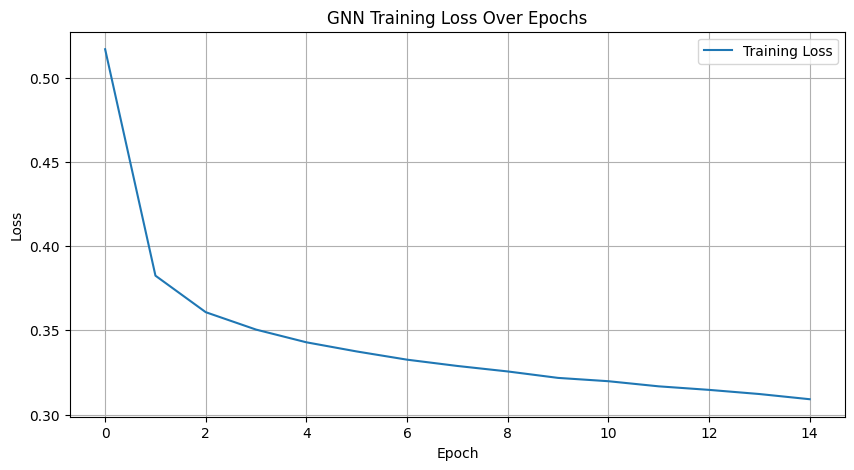

In [ ]:
from tqdm import tqdm


# Training setup
n_epochs = 15
in_features = data.x.shape[1]
hidden_dim = 64
gcn = GCN(in_channels=in_features, hidden_channels=hidden_dim).to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

# Batched training of GNN
def train_gnn_batched(data, model, optimizer, loss_fn, verbose=False):
    all_losses = []

    if verbose:
        # Wrap the DataLoader with tqdm for visual progress
        iterable = tqdm(range(n_epochs), desc=f"Epoch {epoch+1}/{n_epochs}")
    else:
        iterable = range(n_epochs)

    # Loop over each epoch
    for epoch in iterable:
        batch_losses = []

        # Loop over each batch of data in the provided dataset
        for batch_data in data:
            batch_data = batch_data.to(device)

            # Perform a single training step, compute the loss, and return it
            loss = train_gnn_step(
                optimizer,
                loss_fn,
                model,
                batch_data.x,
                batch_data.edge_index,
                batch_data.y  # Ensure that y is masked appropriately
            )
            batch_losses.append(loss)

        # Calculate the average loss of the current epoch (across all batches)
        epoch_loss = sum(batch_losses) / len(batch_losses)
        all_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}: Average Loss {epoch_loss:.4f}")

    return all_losses

all_losses = train_gnn_batched(loader_graph_train, gcn, optimizer, loss_fn)

# Plot the training loss across epochs
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.title('GNN Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


**1.4.5 [1pts]** Predict the label probabilities of each node and evaluate.

In [ ]:
# Your solution here ###########################################################

metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.910
Test metric:     0.915


**1.4.6 [2pts]** Define a new GNN architecture using [graph attention layers][gat].

[gat]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATv2Conv.html#torch_geometric.nn.conv.GATv2Conv

In [ ]:
class GAT(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
        super(GAT, self).__init__()
        '''
        - First GATv2 layer: input_size -> hidden_dim
            - Using multiple heads and concatenating them typically helps learning
        - Second GATv2 layer: hidden_dim -> output_size=1 (binary classification)
        - Activation function: ReLU
        '''
        self.conv1 = pyg.nn.GATv2Conv(in_channels, hidden_channels, heads=8, dropout=0.0)
        self.conv2 = pyg.nn.GATv2Conv(hidden_channels * 8, 1, heads=1, concat=False, dropout=0.0)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        '''
        1. Transform input features by passing them through first GAT layer
        2. Apply ReLU activation function
        3. Pass output through second GAT layer to get output logits
        '''
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.7 [3pts]** Train and evaluate the GAT model with both methods.

FULL TRAINING
Epoch 1: Loss 0.6707658171653748
Epoch 2: Loss 0.6030174493789673
Epoch 3: Loss 0.5501929521560669
Epoch 4: Loss 0.5095944404602051
Epoch 5: Loss 0.47825729846954346
Epoch 6: Loss 0.45346352458000183
Epoch 7: Loss 0.4330635964870453
Epoch 8: Loss 0.4156920909881592
Epoch 9: Loss 0.4006804823875427
Epoch 10: Loss 0.3879074454307556
Epoch 11: Loss 0.3775539994239807
Epoch 12: Loss 0.3699193596839905
Epoch 13: Loss 0.36511218547821045
Epoch 14: Loss 0.36283639073371887
Epoch 15: Loss 0.36234474182128906


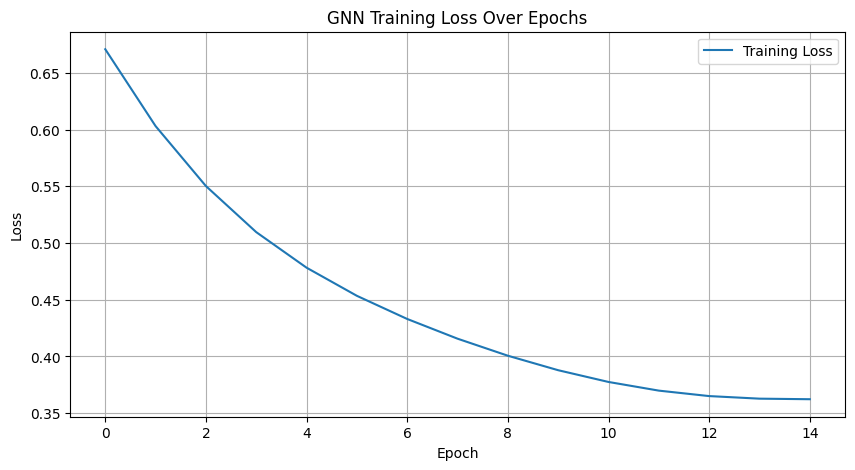

Training metric: 0.901
Test metric:     0.906
BATCH TRAINING
Epoch 1: Average Loss 0.3901
Epoch 2: Average Loss 0.3146
Epoch 3: Average Loss 0.2979
Epoch 4: Average Loss 0.2861
Epoch 5: Average Loss 0.2750
Epoch 6: Average Loss 0.2621
Epoch 7: Average Loss 0.2495
Epoch 8: Average Loss 0.2368
Epoch 9: Average Loss 0.2238
Epoch 10: Average Loss 0.2102
Epoch 11: Average Loss 0.1963
Epoch 12: Average Loss 0.1825
Epoch 13: Average Loss 0.1689
Epoch 14: Average Loss 0.1563
Epoch 15: Average Loss 0.1443


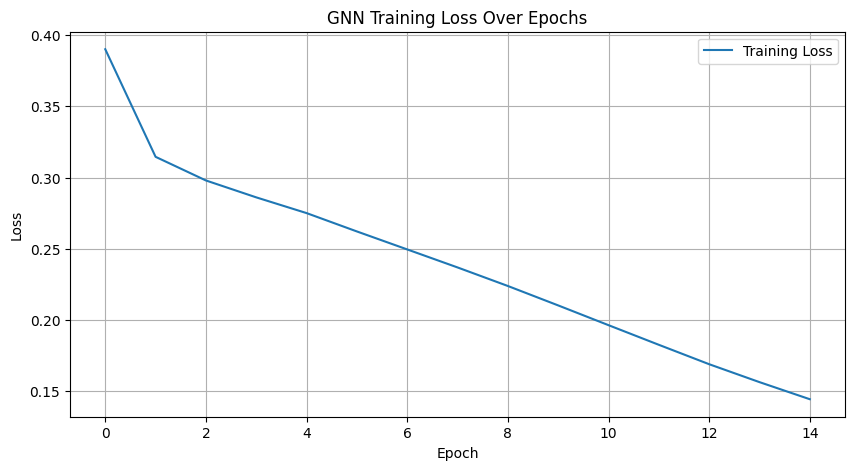

Training metric: 0.962
Test metric:     0.946


In [ ]:
print("FULL TRAINING")

# Your solution here ###########################################################

n_epochs = 15
in_features = data.x.shape[1]
hidden_dim = 64
gat = GAT(in_channels=in_features, hidden_channels=hidden_dim).to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(gat.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

all_losses = train_gnn(data, gat, optimizer, loss_fn)

plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.title('GNN Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

metric_tr, metric_te = eval_gnn(gat, data, train_mask, metric_fn), eval_gnn(gat, data, ~train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#plt.title("Full training")
#plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

print("BATCH TRAINING")

# Your solution here ###########################################################

gat = GAT(in_channels=in_features, hidden_channels=hidden_dim).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

all_losses = train_gnn_batched(loader_graph_train, gat, optimizer, loss_fn)

plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.title('GNN Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

metric_tr, metric_te = eval_gnn(gat, data, train_mask, metric_fn), eval_gnn(gat, data, ~train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

#plt.title("Full training")
#plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

**1.4.8 [6pts]** Compare the results of these two architectures, with multiple hyperparameters, and the previous results. Discuss the eventual differences in performance highlighting the properties that you believe influence most the outcome.

### GCN Results

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 4
Epoch 1: Average Loss 0.6945
Epoch 2: Average Loss 0.5887
Epoch 3: Average Loss 0.5291
Epoch 4: Average Loss 0.4904
Epoch 5: Average Loss 0.4635
Epoch 6: Average Loss 0.4433
Epoch 7: Average Loss 0.4270
Epoch 8: Average Loss 0.4144
Epoch 9: Average Loss 0.4036
Epoch 10: Average Loss 0.3949
Epoch 11: Average Loss 0.3874
Epoch 12: Average Loss 0.3809
Epoch 13: Average Loss 0.3760
Epoch 14: Average Loss 0.3711
Epoch 15: Average Loss 0.3663
Train F1 Score: 0.902, Test F1 Score: 0.904
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 8
Epoch 1: Average Loss 0.5867
Epoch 2: Average Loss 0.4990
Epoch 3: Average Loss 0.439

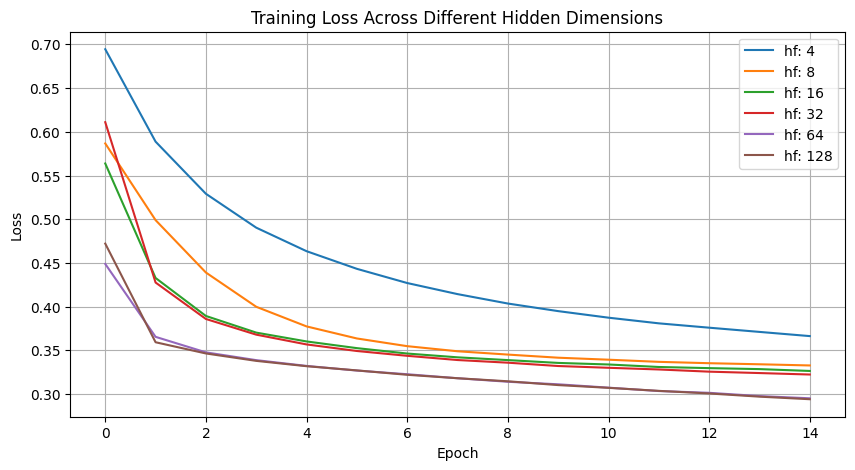

lr: 0.001 


In [ ]:
# Set of hidden dimensions to test
hidden_features = [4,8,16,32,64,128]

# Test setup
in_features = data.x.shape[1]
learning_rate = 0.001
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)
model_evaluation = []

# Initialise plot for the losses
plt.figure(figsize=(10, 5))

for hf in hidden_features:
    print("- - - "*30)
    print('Training with hidden dimension:', hf)

    # Initialise new model and optimizer
    gcn = GCN(in_channels=in_features, hidden_channels=hf).to(device)
    optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)

    # Train model
    losses = train_gnn_batched(loader_graph_train, gcn, optimizer, loss_fn)
    plt.plot(losses, label=f"hf: {hf}")

    # Evaluate model on train and test set
    metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")
    model_evaluation.append({'hidden_dim': hf, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Across Different Hidden Dimensions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print('lr:', learning_rate, "")

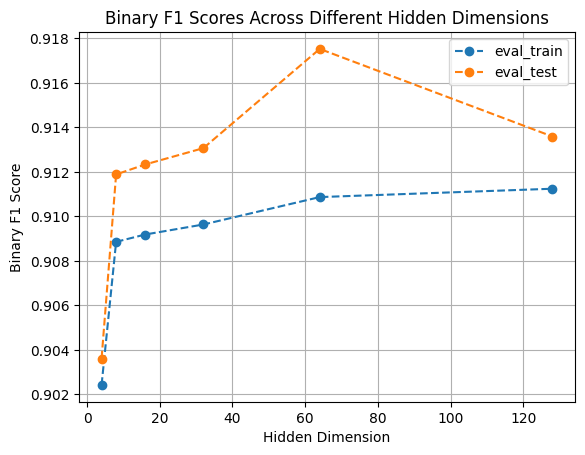

In [ ]:
plt.plot(hidden_features, [x['eval_tr'] for x in model_evaluation], label='eval_train', linestyle='--', marker='o')
plt.plot(hidden_features, [x['eval_te'] for x in model_evaluation], label='eval_test', linestyle='--', marker='o')
plt.title('Binary F1 Scores Across Different Hidden Dimensions')
plt.xlabel('Hidden Dimension')
plt.ylabel('Binary F1 Score')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with learning rate: 0.01
Epoch 1: Average Loss 0.3965
Epoch 2: Average Loss 0.3275
Epoch 3: Average Loss 0.3153
Epoch 4: Average Loss 0.3050
Epoch 5: Average Loss 0.2934
Epoch 6: Average Loss 0.2827
Epoch 7: Average Loss 0.2738
Epoch 8: Average Loss 0.2662
Epoch 9: Average Loss 0.2586
Epoch 10: Average Loss 0.2529
Epoch 11: Average Loss 0.2462
Epoch 12: Average Loss 0.2417
Epoch 13: Average Loss 0.2380
Epoch 14: Average Loss 0.2346
Epoch 15: Average Loss 0.2315
Train F1 Score: 0.889, Test F1 Score: 0.891
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with learning rate: 0.005
Epoch 1: Average Loss 0.4433
Epoch 2: Average Loss 0.3429
Epoch 3: Average Loss 0.32

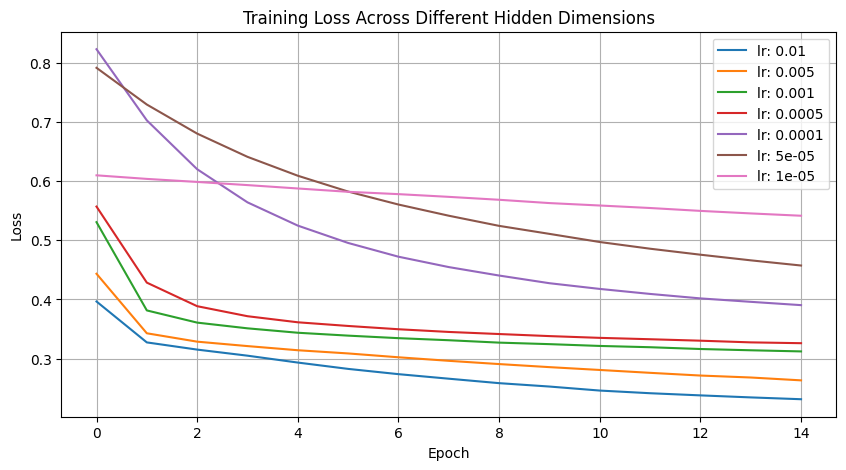

hf: 64


In [ ]:
# Set of hidden dimensions to test
learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

# Test setup
in_features = data.x.shape[1]
hidden_features = 64
learning_rate = 0.001
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)
model_evaluation = []

# Initialise plot for the losses
plt.figure(figsize=(10, 5))

for lr in learning_rates:
    print("- - - "*30)
    print('Training with learning rate:', lr)

    # Initialise new model and optimizer
    gcn = GCN(in_channels=in_features, hidden_channels=hidden_features).to(device)
    optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

    # Train model
    losses = train_gnn_batched(loader_graph_train, gcn, optimizer, loss_fn)
    plt.plot(losses, label=f"lr: {lr}")

    # Evaluate model on train and test set
    metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")
    model_evaluation.append({'hidden_dim': hf, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Across Different Hidden Dimensions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()
print("hf:", hidden_features)

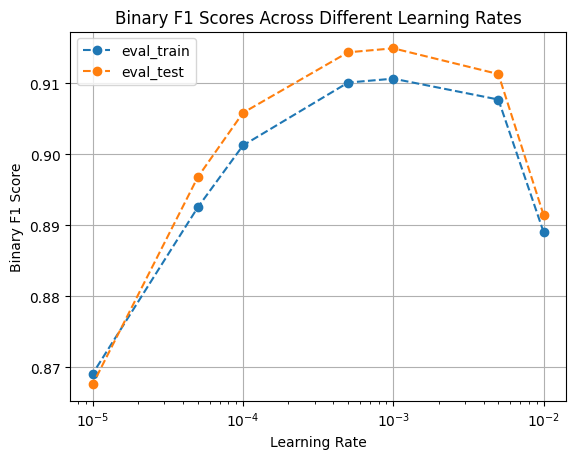

In [ ]:
plt.plot(learning_rates, [x['eval_tr'] for x in model_evaluation], label='eval_train', linestyle='--', marker='o')
plt.plot(learning_rates, [x['eval_te'] for x in model_evaluation], label='eval_test', linestyle='--', marker='o')
plt.title('Binary F1 Scores Across Different Learning Rates')
plt.xlabel('Learning Rate')
plt.semilogx()
plt.ylabel('Binary F1 Score')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

### GAT

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 4
Epoch 1: Average Loss 0.4992
Epoch 2: Average Loss 0.3840
Epoch 3: Average Loss 0.3500
Epoch 4: Average Loss 0.3353
Epoch 5: Average Loss 0.3261
Epoch 6: Average Loss 0.3199
Epoch 7: Average Loss 0.3153
Epoch 8: Average Loss 0.3108
Epoch 9: Average Loss 0.3073
Epoch 10: Average Loss 0.3049
Epoch 11: Average Loss 0.3018
Epoch 12: Average Loss 0.2985
Epoch 13: Average Loss 0.2967
Epoch 14: Average Loss 0.2945
Epoch 15: Average Loss 0.2926
Train F1 Score: 0.911, Test F1 Score: 0.912
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 8
Epoch 1: Average Loss 0.5795
Epoch 2: Average Loss 0.3944
Epoch 3: Average Loss 0.354

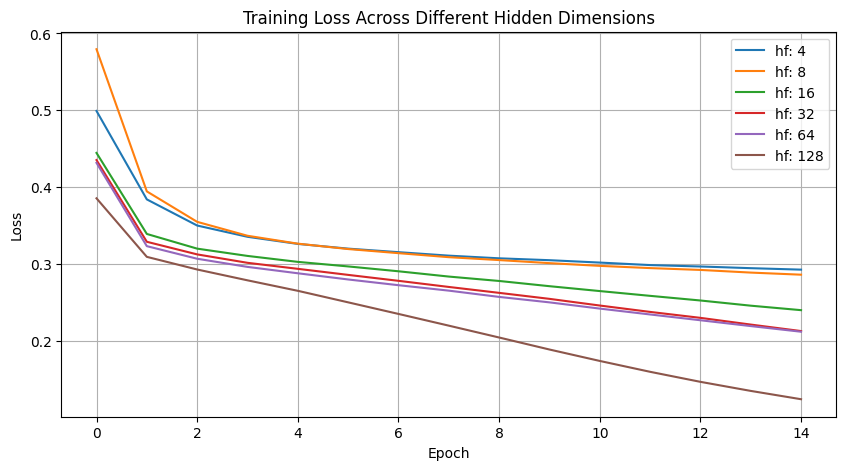

In [ ]:
# Set of hidden dimensions to test
hidden_features = [4,8,16,32,64,128]

# Test setup
in_features = data.x.shape[1]
learning_rate = 0.001
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)
model_evaluation = []

# Initialise plot for the losses
plt.figure(figsize=(10, 5))

for hf in hidden_features:
    print("- - - "*30)
    print('Training with hidden dimension:', hf)

    # Initialise new model and optimizer
    gcn = GAT(in_channels=in_features, hidden_channels=hf).to(device)
    optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)

    # Train model
    losses = train_gnn_batched(loader_graph_train, gcn, optimizer, loss_fn)
    plt.plot(losses, label=f"hf: {hf}")

    # Evaluate model on train and test set
    metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")
    model_evaluation.append({'hidden_dim': hf, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Across Different Hidden Dimensions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print('lr:', learning_rate, "")

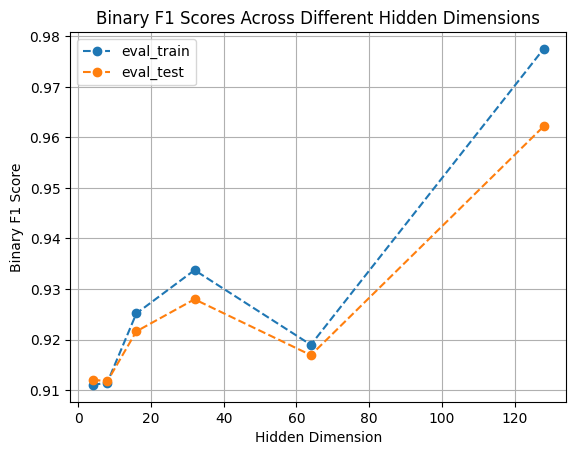

In [ ]:
plt.plot(hidden_features, [x['eval_tr'] for x in model_evaluation], label='eval_train', linestyle='--', marker='o')
plt.plot(hidden_features, [x['eval_te'] for x in model_evaluation], label='eval_test', linestyle='--', marker='o')
plt.title('Binary F1 Scores Across Different Hidden Dimensions')
plt.xlabel('Hidden Dimension')
# plt.xscale('log', base=2)
plt.ylabel('Binary F1 Score')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with learning rate: 0.01
Epoch 1: Average Loss 0.3865
Epoch 2: Average Loss 0.2899
Epoch 3: Average Loss 0.2424
Epoch 4: Average Loss 0.1878
Epoch 5: Average Loss 0.1423
Epoch 6: Average Loss 0.1136
Epoch 7: Average Loss 0.0852
Epoch 8: Average Loss 0.0704
Epoch 9: Average Loss 0.0612
Epoch 10: Average Loss 0.0531
Epoch 11: Average Loss 0.0459
Epoch 12: Average Loss 0.0427
Epoch 13: Average Loss 0.0416
Epoch 14: Average Loss 0.0362
Epoch 15: Average Loss 0.0307
Train F1 Score: 0.980, Test F1 Score: 0.961
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with learning rate: 0.005
Epoch 1: Average Loss 0.3435
Epoch 2: Average Loss 0.2762
Epoch 3: Average Loss 0.23

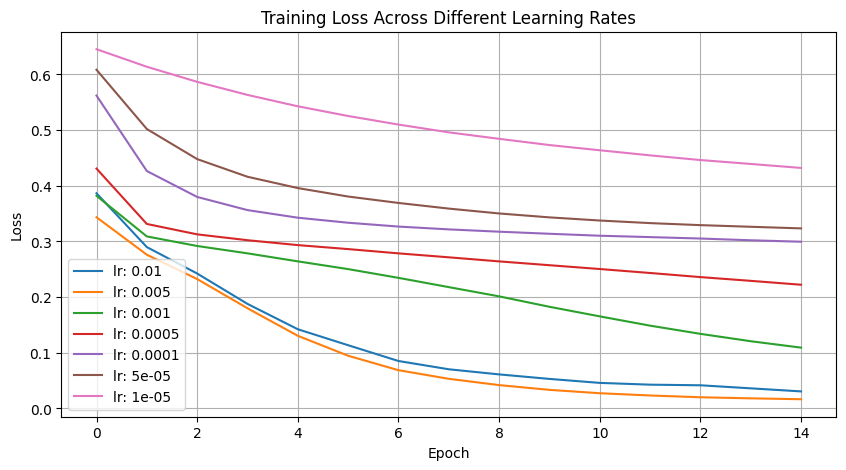

hf: 128


In [ ]:
# Set of hidden dimensions to test
learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

# Test setup
in_features = data.x.shape[1]
hidden_features = 128
learning_rate = 0.001
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)
model_evaluation = []

# Initialise plot for the losses
plt.figure(figsize=(10, 5))

for lr in learning_rates:
    print("- - - "*30)
    print('Training with learning rate:', lr)

    # Initialise new model and optimizer
    gcn = GAT(in_channels=in_features, hidden_channels=hidden_features).to(device)
    optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

    # Train model
    losses = train_gnn_batched(loader_graph_train, gcn, optimizer, loss_fn)
    plt.plot(losses, label=f"lr: {lr}")

    # Evaluate model on train and test set
    metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")
    model_evaluation.append({'hidden_dim': hf, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Across Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()
print("hf:", hidden_features)

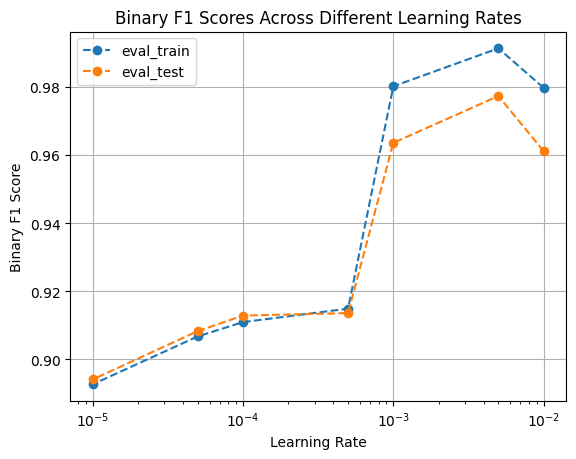

In [ ]:
plt.plot(learning_rates, [x['eval_tr'] for x in model_evaluation], label='eval_train', linestyle='--', marker='o')
plt.plot(learning_rates, [x['eval_te'] for x in model_evaluation], label='eval_test', linestyle='--', marker='o')
plt.title('Binary F1 Scores Across Different Learning Rates')
plt.xlabel('Learning Rate')
# plt.xscale('log', base=10)
plt.semilogx()
plt.ylabel('Binary F1 Score')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**Your answer here:**
NOTE: for this task, we considered batched training as it yielded the better results in the previous task.

From the GCN plots above, we observe that GCN achieves the highest test F1 score for hf=64. Surprisingly, the test F1 scores are better than the train F1 scores across all hidden_dim sizes. As for learning rate, we observe that the smaller ones increasingly struggle to converge, which also results in worse evaluation F1 scores across both training and testing set. We observe that lr=1e-3 yields the best test F1 score. The decrease in test F1 for the two largest learning rates suggests that these learning rates might be too large to find the best observed local optima, and that they may be facilitating overfitting on the train set.

From the GAT plots above, we observe that GAT achieves its highest test F1 score for hf=128. For this particular model structure, higher hidden dimension models appear to yield higher performance. However, to test this hypothesis, we would ideally also run training with hf=256, 512, and even 1024 (they weren't run in our assignment due to computational limitations). As for learning rates, the largest ones appear to unlock the greatest performance, with lr=0.005 achieving an F1 score of approximately 0.98 (the best seen by far).

When comparing the two architectures, GAT appears to consistently outperform GCN across all evaluated sizes of hidden_dim. This can be attributed to the attention mechanisms utilized by GAT, which enable it to focus on the more relevant features in each node's neighborhood (unlike the GCN, which applies the same transformation uniformly across all nodes). Additionally, the performance disparity between GAT and GCN could also be influenced by the capacity of GAT to mitigate issues such as over-smoothing, which occurs when repeated application of the same convolution operation makes the features of nodes in different clusters indistinguishable. GAT's attention mechanism inherently provides a level of adaptivity and locality, preserving more useful information during feature aggregation.

## Part 2: Learning graphs [20 points]

Graph attention layers are quite interesting, since they use the local and the incoming information of a node to give different weights to each neighbor. This is conceptually similar to learning a new graph on top of the existing one.

In this part, we design a block that, from node embeddings, will produce a new graph. The idea is similar to the one in the paper "Discrete Graph Structure Learning for Forecasting Multiple Time Series", which is illustrated in the following Figure.

References:
- C. Shang, J. Chen, and J. Bi, “Discrete Graph Structure Learning for Forecasting Multiple Time Series,” presented at the International Conference on Learning Representations, Feb. 2022. Accessed: Aug. 15, 2022. Available: https://openreview.net/forum?id=WEHSlH5mOk




![Graph Learning Module](graph_learning_module.png)

As we can see from the schema, we have three main components:
1. **Feature extractor**: mapping each node to a new, synthesized representation;
2. **Link predictor**: for each pair of node representations, predict the probability that an edge links them. We gather probabilities in a *structure matrix* $\theta$;
3. **Sampling**: Sample one, or multiple, discrete graphs from the structure matrix.

In the following questions, we will break down these components.

### Question 2.1: Sampling (4 points)

Sampling is the most intriguing part of our module, as it maps, randomly, continuous probabilities to discrete edges.
Ideally, we would like to sample each edge with a probability $\theta$, following a Bernoulli distribution, but this would be hard to backpropagate through.

What we do instead is known as the **Gumbel Trick**.
We sample edges using a [Gumbel][gumbel] reparameterization, which allows differentiating for $\theta$ through it. With $g_{ij}^1, g_{ij}^2 \sim \operatorname{Gumbel}(0,1)$ for all $i,j$, and $s$ a temperature parameter,
$$
A_{ij} = \operatorname{sigmoid}\left(
  \frac{
    \log\left( \frac{\theta_{ij}}{1 - \theta_{ij}} \right)
    + g_{ij}^1 - g_{ij}^2
  }{s}
\right)
.
$$
By letting the temperature go to zero, we can get closer and closer to a Bernoulli distribution.

[gumbel]: https://en.wikipedia.org/wiki/Gumbel_distribution


**2.1.1 [2pts]** Define a function to sample a matrix of Gumbel variables of given shape, knowing that, for $p$ sampled uniformly in (0,1), then $Q(p) \sim \operatorname{Gumbel}(\mu,\beta)$
$$
  Q(p)=\mu-\beta \ln (-\ln (p))
  .
$$

In [ ]:
def sample_gumbel(shape, mu=0, beta=1):
    # Your solution here #######################################################

    '''
    1. Sample uniform variables in (0,1)
    2. Apply the Gumbel inverse CDF transformation
    '''
    uniform_samples = torch.rand(shape)
    return mu - beta * torch.log(-torch.log(uniform_samples))

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("Testing sample_gumbel")
print(sample_gumbel((2, 3), 0, 1))

Testing sample_gumbel
tensor([[-1.0188,  1.3187, -0.0622],
        [ 0.1083, -0.0416,  0.0684]])


**2.1.2 [2pts]** Note that $log(\frac{\theta}{1 - \theta})$ is the sigmoid function, so we can work with unnormalized edge logits instead of probabilities. Define a function to sample an adjacency matrix $A$ from edge logits using the Gumbel Trick.

In [ ]:
def sample_gumbel_trick(logits, temperature, mu=0, beta=1):
    # Your solution here #######################################################
    '''
    1. Draw two Gumbel variables
    2. Apply the Gumbel trick to sample adjacency matrix
    '''
    g1 = sample_gumbel(logits.shape, mu, beta)
    g2 = sample_gumbel(logits.shape, mu, beta)
    return torch.sigmoid((logits + g1 - g2) / temperature)

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing sample_gumbel_trick")
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=10))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1e-2))

Testing sample_gumbel_trick
tensor([1.0000, 0.5539, 0.5035, 0.2472])
tensor([1.0000e+00, 9.0499e-01, 8.1887e-01, 8.9521e-05])
tensor([1., 1., 1., 0.])


### Question 2.2: Link predictor (11 points)

GNNs are all about node embeddings, which by now we should know how to deal with. The missing component is therefore the **link predictor**.

Naively, we could iterate through all pairs of nodes and apply a predictor layer, but it would be highly inefficient.
To leverage tensor manipulation, let's start by gathering paired node representations in a matrix, so that we can predict probabilities in parallel.

**2.2.1 [3pts]**  Define a function that takes as input a tensor of node embeddings, and returns a tensor that concatenate embeddings pairwise. Use [triu_indices][triu_indices] to have pairs appearing only once and avoid self loops, and return the indices along with the embeddings.

[triu_indices]: https://pytorch.org/docs/stable/generated/torch.triu_indices.html

In [ ]:
# COMMENT: alternative implementation -> use a .unsqueeze-operation to get 2D to 3D tensor

def pair_embeddings(x) -> (torch.Tensor, torch.Tensor):
    # This implementation only handles 2D and 3D input tensors (x)
    assert x.dim() in [2,3]

    # Determine if we have batched embeddings or not
    if x.dim() == 3: # -----> Batch mode
        batch_size, num_nodes, _ = x.shape
        # Get the indices of the upper triangular part of the matrix for one example
        row_indices, col_indices = torch.triu_indices(num_nodes, num_nodes, 1)

        # Prepare for batch operation: use broadcasting to get pairs for all batches.
        row_indices, col_indices = row_indices.repeat(batch_size, 1), col_indices.repeat(batch_size, 1)

        # Adjust indices for batched data
        batch_indices = torch.arange(batch_size).repeat_interleave(row_indices.shape[1])
        row_indices, col_indices = row_indices.flatten(), col_indices.flatten()

        # Gather pairs of embeddings based on the indices and concatenate them
        paired_embeddings = torch.cat((x[batch_indices, row_indices], x[batch_indices, col_indices]), dim=1)
    else: # -----> Non-batch mode
        num_nodes = x.size(0)
        row_indices, col_indices = torch.triu_indices(num_nodes, num_nodes, 1)
        paired_embeddings = torch.cat((x[row_indices], x[col_indices]), dim=1)
        batch_indices = None  # No batch indices in non-batch mode

    return paired_embeddings, (row_indices, col_indices, batch_indices)

print("Testing pair_embeddings")
print(pair_embeddings(torch.tensor([[1.0], [2.0], [3.0]]))[0])
print(pair_embeddings(torch.tensor([[[1.0], [2.0], [3.0]], [[4.0], [5.0], [6.0]]]))[0])

Testing pair_embeddings
tensor([[1., 2.],
        [1., 3.],
        [2., 3.]])
tensor([[1., 2.],
        [1., 3.],
        [2., 3.],
        [4., 5.],
        [4., 6.],
        [5., 6.]])


**2.2.2 [8pts]** Define a PyTorch module that takes as input node embeddings, compute link probabilities with a two-layer perceptron on paired embeddings, then samples edges with the Gumbel trick. The output of the forward method will be a PyTorch Geometric [EdgeIndex][edge_index] of tensors representing indices and weights corresponding to positively sampled edges. You might need a `eps` threshold to avoid numerical errors.

[edge_index]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.edge_index.EdgeIndex

In [ ]:

class MLPGraphLearn(nn.Module):
    # Your solution here ###########################################################
    def __init__(self, in_features: int, hidden_features: int, temperature: float, eps=1e-10):
        super(MLPGraphLearn, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features * 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, 1)
        )
        self.temperature = temperature
        self.eps = eps

    def forward(self, x):
        '''
        1. Pair embeddings and retrieve indices
        2. Pass the paired embeddings through the MLP to obtain logits
        3. Apply the Gumbel trick to obtain sampled probabilities
        4. Filter edges where the probability is above a threshold to handle numerical issues
        5. Prepare edge indices with corresponding weights for the positively sampled edges
        '''
        paired_embeddings, (row_indices, col_indices, _) = pair_embeddings(x)
        logits = self.mlp(paired_embeddings).squeeze(-1)
        sampled_probs = sample_gumbel_trick(logits, self.temperature)
        mask = sampled_probs > self.eps
        edge_indices = pyg.EdgeIndex(torch.stack([row_indices[mask], col_indices[mask]], dim=0)) # create EdgeIndex object

        edge_weights = sampled_probs[mask]
        return edge_indices, edge_weights

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("Testing MLPGraphLearn")
mlp_gl = MLPGraphLearn(2, 5, 0.01)
mlp_gl(torch.tensor([[[1.0, 2.0], [0.5, 7.1], [-0.1, 0.3]]]))

Testing MLPGraphLearn


(EdgeIndex([[0, 0, 1],
            [1, 2, 2]], nnz=3),
 tensor([1., 1., 1.], grad_fn=<IndexBackward0>))

### Question 2.3: Classifiers with Graph Learning Module (5 points)

Let's introduce our graph learning block into some classifiers.


**2.3.1 [4pts]** Define a classifier that first produces node embeddings with a Linear layer with ReLU activation, which it feeds to the previously defined GL module; then it performs two graph convolutions on the original node features using the learned graph.

In [ ]:
class MLPGLClassifier(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_features: int, gl_node_features_in: int = 64, gl_node_features_hidden: int = 32, gcn_hidden: int = 64,):
        super(MLPGLClassifier, self).__init__()

        # Embedding: Linear layer + ReLU activation
        self.embedding = nn.Sequential(
            nn.Linear(in_features, gl_node_features_in),
            nn.ReLU()
        )

        # GL: Instance of previously implemented module
        self.graph_learner = MLPGraphLearn(
            in_features=gl_node_features_in,
            hidden_features=gl_node_features_hidden,
            temperature=0.5  # Temperature not provided as a arg
        )

        # Two layer GCN architecture for classification on learned graph
        self.gcn1 = pyg.nn.GCNConv(in_channels=gl_node_features_in, out_channels=gcn_hidden)
        self.gcn2 = pyg.nn.GCNConv(in_channels=gcn_hidden, out_channels=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        '''
        1. Create embedding of x
        2. Get edge_index from graph learner (link predictor)
        3. Standard GCN forward pass of embedded x + edge_index
        '''
        x = self.embedding(x)
        edge_index, edge_weights = self.graph_learner(x)
        x = self.gcn1(x, edge_index)
        x = self.relu(x)
        x = self.gcn2(x, edge_index)

        return x
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**2.3.2 [1pt]** Unfortunately, training and evaluating the `MLPGLClassifier` might take too long. Let's just test whether it works: instantiate the classifier and compute the graph embedding.

In [ ]:
# Your solution here ###########################################################
'''
We see several possibilities for what was sought with the term 'graph embedding'. The most logical
assumption to us is that by 'graph embedding' we are asked for a single vector that represents the
input graph. Because (1) we are left to create our own input graph, (2) our MLPGLClassifer class handles
node-level embeddings, and (3) we are asked to define MLPGClassifier as a 'classifier', we further
assume that the embedding sought is a vector of node-level logits calculated by our classifier. This
is what we return from the classifier call below.

We did not print the embeddings from the initial fully-connected layer because they were node-level
rather than graph level.
'''

# Initialize classifier
classifier = MLPGLClassifier(in_features=10,
                             gl_node_features_in=64,
                             gl_node_features_hidden=32,
                             gcn_hidden=64)

# Create dummy input
dummy_input = torch.randn(5, 10)

try:
    graph_embeddings = classifier(dummy_input)
    print("Output Shape:", graph_embeddings.shape)
    print("Output:", graph_embeddings)
except Exception as e:
    print("An error occurred during forward pass:", str(e))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Output Shape: torch.Size([5, 1])
Output: tensor([[-0.6903],
        [-0.8367],
        [-0.8909],
        [-0.8980],
        [-0.9224]], grad_fn=<AddBackward0>)


## Part 3 (Theory): Forcing causal structure in learned graphs [35 points]

Understanding and mapping the causal relationships among data variables, represented by directed acyclic graphs (DAGs), presents a significant challenge. The search space for these DAGs is combinatorial, and it scales super exponentially with the number of nodes, further complicating the task.

Assuming causal relationships between data variables, the basic DAG learning problem is formulated as follows: Let $\mathbf{X} \in \mathbb{R}^{n \times d}$ be a data matrix consisting of $n$ i.i.d. observations of the random vector $x=\left(x_1, \ldots, x_d\right)$ and let $\mathbb{D}$ denote the (discrete) space of DAGs $\mathrm{G}=(\mathrm{V}, \mathrm{E})$ on $d$ nodes. Given $\mathbf{X}$, we seek to learn a DAG $\mathrm{G}$ represented by its adjacency matrix $A$ such that:

$$
\begin{array}{rl}
\min _{A \in \mathbb{R}^{d \times d}} &  F(A):= \frac{1}{2 n}\|\mathbf{X}-GNN(\mathbf{X}, A)\|_F^2+\lambda\|A\|_1 \\
\text { subject to } &  A \in \mathbb{D} ,
\end{array}
$$
where $\mathbb{D}$ represents a DAG space and GNN is a graph neural network that simultaneously learns a DAG $A$ and accurately predicts an estimation of the matrix $\mathbf{X}$. The minimization of the aforementioned problem guides us towards finding the causal graph that generates the data $\mathbf{X}$. Although $F(A)$ is continuous, the DAG constraint $A \in \mathbb{D}$ remains a challenge to enforce.

The objective is to make the aforementioned problem amenable to black-box optimization (in order to use SGD, ADAM...). We aim to replace the combinatorial acyclicity constraint $A \in \mathbb{D}$ with a single smooth equality constraint $h(A) = 0$. Thus, the objective of this section is to find a smooth function $h: \mathbb{R}^{d \times d} \rightarrow \mathbb{R}$ that will satisfy the following: $h(A)=0$ if and only if $A$ is acyclic (i.e. $A \in \mathbb{D}$). Furthermore, we want to ensure that $h$ and its derivatives are easy to compute.

$\color{red}{\text{!!!!! PLEASE NOTE !!!!!}}$

Many of our solutions in part 3 are inspired or directly based on the following paper:

Xun Zheng, Bryon Aragam, Pradeep Ravikumar, and Eric P. Xing. 2018. DAGs with NO TEARS: continuous optimization for structure learning. In Proceedings of the 32nd International Conference on Neural Information Processing Systems (NIPS'18). Curran Associates Inc., Red Hook, NY, USA, 9492–9503.

This and other sources are listed beneath a proof where applicable.

$\color{red}{\text{---}}$

### Question 3.1: DAGness property for binary matrix with spectral radius condition (8 points)

In this question we want to find out when a matrix $A \in\{0,1\}^{d \times d}$ corresponds to an acyclic graph.

Suppose $A \in\{0,1\}^{d \times d}$ and $r(A)<1$, $r(A)$ is the spectral radius of the matrix $A$, and it corresponds to the largest absolute eigenvalue of $A$.



**3.1.1 [2pts]** Justify the convergence of $\sum_{k=0}^{\infty} A^k$ and show that:
$$\left(I_n-A\right)^{-1}=\sum_{k=0}^{\infty} A^k$$

**Your answer here:**

We have that the largest absolute eigenvalue of A is less than 1. This implies all eigenvalues of A have magnitude less than 1. Letting $\lambda _{1}, \lambda _{2}, ..., \lambda _{n}$ be the eigenvalue set $E$ of $A$, the eigenvalues of $A^k$ must equal $\lambda _{1}^k, \lambda _{2}^k, ..., \lambda _{n}^k.$ But $\lim_{{k \to \infty}}\lambda_i^k = 0 \ \forall \ \lambda_i \in E$, meaning all eigenvalues for square matrix $A^k$ converge to 0 as ${k \to \infty}$. $A^k$ therefore converges to a nilpotent matrix as ${k \to \infty}$, which in turn implies the terms of $\sum_{k=0}^{\infty}A^k$ must converge to the 0 matrix. Because all constituent entries in the matrix power series are linear combinations of 0s and 1s, and because $\lim_{{k \to \infty}}A^k$ converges to the 0 matrix, $\sum_{k=0}^{\infty} A^k$ converges.

We now show $\left(I_n-A\right)^{-1}=\sum_{k=0}^{\infty} A^k$.

Let $P_i = \sum_{k=0}^{i}A^k$. Then:

$(I_n - A)\lim_{{i \to \infty}}P_i = \lim_{{i \to \infty}}(I_n-A)P_i = \lim_{{i \to \infty}}(P_i - AP_i) = $

$\lim_{{i \to \infty}}(\sum_{k=0}^{i}A^k - \sum_{k=0}^{i}A^{k+1}) = \lim_{{i \to \infty}}(I_n + \sum_{k=1}^{i}A^k - \sum_{k=1}^{i}A^{k} - A^{k+1}) = \lim_{{i \to \infty}}(I_n - A^{k+1}).$

We established above that $\sum_{k=0}^{\infty} A^k$ converges, which means as $k$ approaches infinity, the entries of $A^{k+1}$ must converge to 0. Thus:

$\lim_{{i \to \infty}}(I_n - A^{k+1}) = (I_n - \bf{0}) = I_n.$

But notice $\lim_{{i \to \infty}}P_i = \sum_{k=0}^{\infty} A^k$, meaning we have shown $(I_n - A)\sum_{k=0}^{\infty} A^k = I_n$. Multiplying both sides by $(I_n - A)^{-1}$, this in turn implies $\sum_{k=0}^{\infty} A^k = (I_n - A)^{-1}.$

--

source: [Neumann series wiki](https://en.wikipedia.org/wiki/Neumann_series)

---


**3.1.2 [6pts]** Show that $A$ is a $D A G$ if and only if $\operatorname{tr}(I-A)^{-1}=d$

**Your answer here:**

We have from 3.1.1 that $\left(I_n-A\right)^{-1}=\sum_{k=0}^{\infty} A^k$.

Thus, $\operatorname{tr}((I-A)^{-1})=\operatorname{tr}(\sum_{k=0}^{\infty} A^k)$ -> linearity of summation -> $\sum_{k=0}^{\infty}\operatorname{tr}(A^k) = \operatorname{tr}(A^0) + \sum_{k=1}^{\infty}\operatorname{tr}(A^k)$

Since $A \in\{0,1\}^{d \times d}$, $\operatorname{tr}(A^0) = \operatorname{tr}(I \in \{0,1\}^{d \times d}) = d$.

So $\operatorname{tr}(I-A)^{-1} = d + \sum_{k=1}^{\infty}\operatorname{tr}(A^k) = d + \sum_{k=1}^{\infty}\sum_{i=1}^{d}{A^k}_{ii}$.

But an adjacency matrix describes a DAG iff there are 0 cycles - that is, iff there are 0 directed paths of any length between a node and itself. This is equivalent to saying ${A^k}_{ii} = 0$ $\forall k > 0$ (see Lecture 1 - Graph Theory basics, slide 42).

Hence, an adjacency matrix A describes a DAG iff $\sum_{k=1}^{\infty}\sum_{i=1}^{d}{A^k}_{ii} = 0.$

If follows that an adjacency matrix A is a DAG iff $\operatorname{tr}((I-A)^{-1}) = d + \sum_{k=1}^{\infty}\sum_{i=1}^{d}{A^k}_{ii} = d + 0 = d$.

Note: we have assumed by $\operatorname{tr}(I-A)^{-1}=d$ you mean $\operatorname{tr}((I-A)^{-1})=d$. (we like using the parentheses to enclose a trace even if the original paper doesn't).

--

source: [DAGs with NO TEARS](https://arxiv.org/pdf/1803.01422)

---

Having an assumption on $r(A) < 1$ limits the application of our results. For this reason, our objective is to generalize the previous result to binary matrices.


### Question 3.2: DAGness property for binary matrix (8 points)

Suppose $A \in\{0,1\}^{d \times d}$.

**3.2.1 [4pts]**  Prove the existence of the exponential matrix, we recall that $e^{A} = \sum_{k=0}^{\infty} \frac{A^k}{k !}$


**Your answer here:**

Suppose to the contrary that for some adjacency matrix $A \ \nexists \ e^{A} = \sum_{k=0}^{\infty} \frac{A^k}{k !} $.

Then for some $k$, either $k ! = 0$, $k !$ is undefined, or $A^k$ is undefined.

But since $k \geq 0$ and $k \in \mathbb{N}$, $k! \geq 1$ and $k! \in \mathbb{Z} \ \forall \ k$. Hence $k !$ is always defined and can never equal 0.

Furthermore, since $A \in\{0,1\}^{d \times d}$, we know that regardless of $k$ every product $A^k$ will multiply successive matrices of dimensions ${d \times d}$ - meaning matrix multiplication can always occur - and all values in $A^k$ will be in $\mathbb{N}$ (as they will be linear combinations of 0s and 1s). Hence, $A^k$ is always defined.

Since neither $k !$ nor $A^k$ can be undefined and $k !$ cannot equal 0, there cannot exist a $k$ for which $\frac{A^k}{k !}$ is undefined, and we have reached a contradiction. This means $e^{A} = \sum_{k=0}^{\infty} \frac{A^k}{k !}$ exists for all A.

---

**3.2.2 [4pts]** Show that $A$ is a $D A G$ if and only if $\operatorname{tr} e^A=d$, where $e^A$ is the exponential matrix.

**Your answer here:**

We have from 3.2.1 that $e^{A} = \sum_{k=0}^{\infty} \frac{A^k}{k !}$ converges.

Thus, $\operatorname{tr}(e^{A})=\operatorname{tr}(\sum_{k=0}^{\infty} \frac{A^k}{k !})$ -> linearity of summation -> $\sum_{k=0}^{\infty}\operatorname{tr}(\frac{A^k}{k !}) = \operatorname{tr}(A^0) + \sum_{k=1}^{\infty}\operatorname{tr}(\frac{A^k}{k !})$

Since $A \in\{0,1\}^{d \times d}$, $\operatorname{tr}(A^0) = \operatorname{tr}(I \in \{0,1\}^{d \times d}) = d$.

So $\operatorname{tr}(e^{A}) = d + \sum_{k=1}^{\infty}\operatorname{tr}(\frac{A^k}{k !}) = d + \sum_{k=1}^{\infty}\frac{1}{k !}\sum_{i=1}^{d}(A^k)_{ii}$.

As in 3.1.2, an adjacency matrix A describes a DAG iff ${A^k}_{ii} = 0$ $\forall k > 0$ (see Lecture 1 - Graph Theory basics, slide 42).

Hence, an adjacency matrix A describes a DAG iff $\sum_{k=1}^{\infty}\frac{1}{k !}\sum_{i=1}^{d}{A^k}_{ii} = \sum_{k=1}^{\infty}\frac{1}{k !}(0) = 0$.

If follows that an adjacency matrix A is a DAG iff $\operatorname{tr}(e^{A}) = d + \sum_{k=1}^{\infty}\frac{1}{k !}\sum_{i=1}^{d}{A^k}_{ii} = d + 0 = d$.

--

source: [DAGs with NO TEARS](https://arxiv.org/pdf/1803.01422)

---

**3.3 [5pts]** DAGness property for weighted adjacency matrices

Suppose $A \in \mathbb{R}^{d \times d}$. Knowing that the equivalence of Question 3.2 is correct for any nonnegative weighted matrix $A$, propose a function $f$ such that $A$ is a $D A G$ if and only if $\operatorname{tr} e^{f(A)}=d$.


**Your answer here:**

Let $f(A) = A \odot A =$ the Hadamard product of A with itself. In other words, let $f(A)$ be the matrix that results from squaring each element of A; $(A \odot A)_{ij} = A_{ij}A_{ij}$.

We have from 3.2.2 and the 3.3 prompt that $\operatorname{tr} e^A=d$ provided A is nonnegative (ie each of its elements is nonnegative) iff A is a DAG. Meanwhile, $f(A)$ is nonnegative, as any nonpositive element of A becomes nonnegative when squared with itself. Furthermore, $A \in \mathbb{R}^{d \times d} \implies A \odot A \in \mathbb{R}^{d \times d}$ because the square of a real number is also a real number. Hence $ \exists \ f(A) \ \forall \ A $.

Replacing $A$ with $f(A)$ in the equality from 3.2.2:

$\operatorname{tr}(e^{f(A)})=\operatorname{tr}(\sum_{k=0}^{\infty} \frac{(A \odot A)^k}{k !})$ -> linearity of summation -> $\sum_{k=0}^{\infty}\operatorname{tr}(\frac{(A \odot A)^k}{k !}) = \operatorname{tr}((A \odot A)^0) + \sum_{k=1}^{\infty}\operatorname{tr}(\frac{(A \odot A)^k}{k !}) = d + \sum_{k=1}^{\infty}\operatorname{tr}(\frac{(A \odot A)^k}{k !}) = d + \sum_{k=1}^{\infty}\frac{1}{k !}\sum_{i=1}^{d}((A \odot A)^k)_{ii}$

It remains to prove $\sum_{k=1}^{\infty}\frac{1}{k !}\sum_{i=1}^{d}((A \odot A)^k)_{ii} = 0$.

Now, since $a^2_{ij} = 0$ iff $a_{ij} = 0$ and $a^2_{ij} \neq 0$ iff $a_{ij} \neq 0 \ \forall \ a_{ij} \in A$, $A$ and $A \odot A$ share the same edge sets (if not the same edge weights). $A = DAG \iff A \odot A = DAG$.

As referenced in 3.1.2 and 3.2.2, an adjacency matrix B describes a DAG iff ${B^k}_{ii} = 0$ $\forall k > 0$ (see Lecture 1 - Graph Theory basics, slide 42).

Thus, since $A \odot A$ is a DAG, $\sum_{k=1}^{\infty}\frac{1}{k !}\sum_{i=1}^{d}((A \odot A)^k)_{ii} = \sum_{k=1}^{\infty}\frac{1}{k !}(0) = 0$, meaning $\sum_{k=1}^{\infty}\operatorname{tr}(\frac{(A \odot A)^k}{k !}) = 0$.

It follows that $f(A)$ is specified such that $A$ is a $D A G$ if and only if $\operatorname{tr}(e^{f(A)=A \odot A})=d$.

--

source: [DAGs with NO TEARS](https://arxiv.org/pdf/1803.01422)

---

**3.4 [7pts]** Compute the gradient of $h(A) = \operatorname{tr} e^{f(A)}-d$.

**Your answer here:**

If $h(A) = \operatorname{tr}(e^{A \odot A})-d$, then

$\nabla h(A) = \frac{\partial}{\partial A}\operatorname{tr}(e^{A \odot A}) - \frac{\partial}{\partial A}d = \frac{\partial}{\partial A}\operatorname{tr}(e^{A \odot A}) - 0 = \frac{\partial}{\partial A}\operatorname{tr}(e^{A \odot A}) = \frac{\partial}{\partial A}\sum_{i=1}^{d}{e^{A \odot A}}_{ii} = \sum_{i=1}^{d}\frac{\partial}{\partial A}{e^{A \odot A}}_{ii} = \langle I, \frac{\partial}{\partial A}{e^{A \odot A}} \rangle_F$.

Let $S = A \odot A$. Then:

$\langle I, \frac{\partial}{\partial A}{e^{A \odot A}} \rangle_F = \langle I, \frac{\partial}{\partial A}{e^{S}} \rangle_F = \langle I, \frac{\partial}{\partial S}{e^{S}}\frac{\partial}{\partial A}{S} \rangle_F = \operatorname{tr}(I^T\frac{\partial}{\partial S}{e^{S}}\frac{\partial}{\partial A}{S}) = \langle I(\frac{\partial}{\partial S}{e^{S}})^T,\frac{\partial}{\partial A}{S} \rangle_F = \langle I(e^{S})^T,\frac{\partial}{\partial A}{S} \rangle_F = \langle (e^{S})^T,\frac{\partial}{\partial A}{S} \rangle_F$.

Now, $\frac{\partial}{\partial A}{S} = \frac{\partial}{\partial A}{A \odot A} = A \odot \frac{\partial}{\partial A}A + \frac{\partial}{\partial A}A \odot A $ -> commutative, distributive -> $2A \odot \frac{\partial}{\partial A}A.$

Then $\nabla h(A) = \langle (e^{S})^T,2A \odot \frac{\partial}{\partial A}A \rangle_F$ -> mutual commutativity -> $\langle (e^{S})^T \odot 2A, \frac{\partial}{\partial A}A \rangle_F$.

But $\frac{\partial}{\partial A}A$ is a matrix with 1 for each element. So $\nabla h(A) = (e^{S})^T \odot 2A = (e^{A \odot A})^T \odot 2A$.

--

sources:

general structure: [stackexchange quoting from DAGs with NO TEARS](https://math.stackexchange.com/questions/4727042/on-the-weighted-adjacency-matrix-of-a-directed-acyclic-graph-dag)

trace tricks, specifically tr(AB) = <A^T, B>: [wiki](https://en.wikipedia.org/wiki/Trace_(linear_algebra)), [stackexchange](https://math.stackexchange.com/questions/1898839/relation-between-frobenius-norm-and-trace)

for commutative and distributive of hadamard: [wiki](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))

for gradient of hadamard product and mutual commutativity: [stackexchange](https://math.stackexchange.com/questions/2307026/gradient-hadamard-product)

---

**3.5 [7pts]** Other alternatives

Suppose $A \in \mathbb{R}^{d \times d}$. For the previously proposed function $f$ show that for any $\alpha > 0 $, $A$ is a $D A G$ if and only if $\operatorname{tr}\left[(I+\alpha f(A))^d\right]-d=0$.

**Your answer here:**
**Your answer here:**

We must show A is a $DAG$ iff $\operatorname{tr}\left[(I+\alpha (A \odot A))^d\right]-d=0$.

Observe $\operatorname{tr}\left[(I+\alpha (A \odot A))^d\right]-d=0 \implies \operatorname{tr}\left[(I+\alpha (A \odot A))^d\right]=d.$

Because $A$ is an adjacency matrix and $f(A)$ does not add or remove edges, $(A \odot A)$ is an adjacency matrix that has the same edge set (but not edge weights) as $A$. Similarly, because $\alpha > 0$, $\alpha(A \odot A)$ is an adjacency matrix that has the same edge set (but not edge weights) as $A$. Finally, in terms of the original graph, by adding $I$ to $\alpha(A \odot A)$, we are adding exactly $d$ edges to the original edge set: one self-loop at each node. Thus, the edge set for adjacency matrix $W = I+\alpha (A \odot A)$ contains all the same edges as A along with $d$ new self-loops.

We must now prove that A is a $DAG$ iff $\operatorname{tr}(W^d) = d$.

From 3.3 we have that $A \odot A$ is a $DAG$ iff $A$ is a $DAG$. By logic similar to that mentioned in 3.3, $\alpha (A \odot A)$ is a $DAG$ iff $A$ is a $DAG$ (because the scaling factor $\alpha > 0$ does not change whether an entry is zero or nonzero and therefore does not add or remove edges in the adjacency matrix). Therefore, $W = I + D_{DAG}$, where $D_{DAG} = \alpha(A \odot A)$ is a $DAG$, iff $A$ is a $DAG$. $W$ itself is clearly not a $DAG$; that each node has a self-loop precludes this.

We now claim that any cycle of arbitrary length $l$ starting and ending at node $n$ in $W$ must be composed of $l$ traversals of the single self-loop attached to $n$. To see why this is the case, suppose to the contrary that there is a cycle of length $l$ starting and ending at $n$ that traverses at least one non-self-loop edge. Then, because $I$ in the sum $I + D_{DAG}$ does not add any edges *between* nodes to $D_{DAG}$, the cycle must be relying on one or more edges from $D_{DAG}$ to eventually return to $n$. Furthermore, in this scenario, the path would still constitute a cycle from $n$ to $n$ if any self-loop traversals were removed since self-loop traversals do not change the active node on a path. This would mean the supposed path is (or has a subset that contains) a cycle that depends exclusively on edges from $D_{DAG}$. But we know $D_{DAG}$ is a $DAG$, and that such a path cannot exist. We have reached a contradiction. As a result, there can be no cycle of length $l$ that is not composed of $l$ traversals of a node's self-loop. Because each node in $W$ has just one self-loop edge due to $I$, this also means there are $d$ total cycles of length $l$ in W - one for each node.

Per slide 42 of Lecture 1 - Graph Theory basics, ${W^d}_{ij}$ is equal to the number of paths of length $d$ between nodes $i$ and $j$. Hence, according to the paragraph above, if $A$ is a $DAG$ then $\operatorname{tr}(W^d) = \sum_{k=1}^{d}{W^d}_{kk} = 1 + ... + 1 = d$.

We have proven $A = DAG \implies \operatorname{tr}(W^d) = \operatorname{tr}\left[(I+\alpha (A \odot A))^d\right] = d$. To see why the latter implies the former, suppose to the contrary that $\operatorname{tr}(W^d) = d$ but $W = I + E_{notDAG}$, where $E_{notDAG} = \alpha(A \odot A)$ is not a $DAG$ (meaning $A$ is necessarily not a $DAG$). Then there would exist a cycle $c$ of length $l \leq d$ in $E_{notDAG}$ for some node $n$. If $l = d$, it is obvious that both $c$ and the full self-loop cycle for $n$ induced by $I$ would be included in ${W^d}_{nn}$, meaning ${W^d}_{nn} > 1$ and $\operatorname{tr}(W^d) > d$. If $l < d$, one could add $d-l$ self-loop traversals to the cycle $c$ to increase its length, increment ${W^d}_{nn}$, and cause $\operatorname{tr}(W^d) > d$. By contradiction in both cases, we have that $\operatorname{tr}(W^d) = d \implies A$ is a $DAG$ (where $W = I+\alpha (A \odot A))$. The original iff statement is thus proved.